In [55]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from collections import defaultdict
from collections import Counter
from time import time
import re

import spacy
# from spacy import displacy # see if we need that
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix


### Import data set:


In [56]:
pd.options.mode.chained_assignment = None

col_list = ['text', 'class']
df_full = pd.read_csv('data/data_set.csv', usecols=col_list)
df = df_full[['text']]

df["text"] = df["text"].astype(str)
df_full.head()
df.head()


,text
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


# Text preprocessing:


## Lower casing:


In [57]:

df["text_lower"] = df["text"].str.lower()
df.head()


,text,text_lower
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


## Punctuation removal:


In [58]:
PUNCTUATION_TO_REMOVE = '–«!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~»●·’“”'


def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCTUATION_TO_REMOVE))


df["text_wo_punct"] = df["text_lower"].apply(
    lambda text: remove_punctuation(text))
df.head()


,text,text_lower,text_wo_punct
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...


## Stopwords removal:


In [59]:
stopwords_lower = list(map(lambda x: x.lower(), stopwords.words('greek')))

STOPWORDS_GREEK = set(stopwords_lower)

# text_tokens = word_tokenize(text) use nltk tokenization


def import_additional_greek_stopwords(STOPWORDS_GREEK):

    additional_stopwords = open('additional_stopwords.txt', 'r')
    for line in additional_stopwords:
        words = line.strip()
        STOPWORDS_GREEK.add(words)
    return STOPWORDS_GREEK


STOPWORDS_GREEK = import_additional_greek_stopwords(STOPWORDS_GREEK)
# print(STOPWORDS_GREEK)


def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if not word in STOPWORDS_GREEK])


df["text_wo_stop"] = df["text_wo_punct"].apply(
    lambda text: remove_stopwords(text))
df.head()


,text,text_lower,text_wo_punct,text_wo_stop
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...","""ξεκίνησε το πρωί ενώπιον των δικαστών του μικ...",ξεκίνησε το πρωί ενώπιον των δικαστών του μικτ...,ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...","""στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσε...,άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...","""δεν λέει κουβέντα ο γερμανός καταδικασμένος π...",δεν λέει κουβέντα ο γερμανός καταδικασμένος πα...,λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...","""2,5 χρόνια μετά από τον θάνατο της ειρήνης λα...",25 χρόνια μετά από τον θάνατο της ειρήνης λαγο...,25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...","""μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",μία εβδομάδα μετά την αρχική του εκτίμηση ότι ...,εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...


## Lemmatization:


In [60]:
# # Drop the columns which are no longer needed
df.drop(["text_lower", "text_wo_punct"], axis=1, inplace=True)

nlp = spacy.load("el_core_news_sm")
# nlp.remove_pipe("tagger")


def lemmatize_words(text):
    """custom function to lemmatize text"""
    doc = nlp(text)
    # pos_tagged_text = text.pos
    return " ".join([token.lemma_ for token in doc])


df["text_lemmatized"] = df["text_wo_stop"].apply(
    lambda text: lemmatize_words(text))
df.head()


,text,text_wo_stop,text_lemmatized
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκίνώ πρωί ενώπιον δικαστής μικτός ορκωτού εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...,άκρο περάσω διαδηλώση ηπας δολοφονία τζορτζ φλ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λέω κουβέντος γερμανός καταδικασμένος παιδόφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρόνια θάνατο ειρήνη λαγούδη μητέρας τριών ...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...,εβδομάδα αρχικός εκτίμηση μαντλίν μακκαν νεκρό...


## Intonation removal:


In [61]:
def remove_intonation(text):

    rep = {"ά": "α", "έ": "ε", "ή": "η", "ί": "ι", "ό": "ο", "ύ": "υ", "ώ": "ω", "ϊ": "ι",
           "ἀ": "α", "ἐ": "ε", "ἤ": "η", "ἰ": "ι", "ἄ": "α", "ὐ": "υ", "ὡ": "ω", "ὦ": "ω",
           'ὖ': 'υ', 'ὅ': 'ο', 'ῆ': 'η', 'ῇ': 'η', 'ῦ': 'υ', 'ὁ': 'ο', 'ὑ': 'υ', 'ὲ': 'ε',
           'ὺ': 'υ', 'ἂ': 'α', 'ἵ': 'ι', 'ὴ': 'η', 'ὰ': 'α', 'ἅ': 'α', 'ὶ': 'ι', 'ἴ': 'ι',
           'ὸ': 'ο', 'ἥ': 'η', 'ἡ': 'η', 'ὕ': 'υ', 'ἔ': 'ε', 'ἳ': 'ι', 'ὗ': 'υ', 'ἃ': 'α',
           'ὃ': 'ο', 'ὥ': 'ω', 'ὔ': 'υ', 'ῖ': 'ι', 'ἣ': 'η', 'ἷ': 'ι', 'ἑ': 'ε', 'ᾧ': 'ω',
           'ἢ': 'η', 'ΐ': 'ι', }

    rep = dict((nltk.re.escape(k), v) for k, v in rep.items())
    pattern = nltk.re.compile("|".join(rep.keys()))
    text = pattern.sub(lambda m: rep[nltk.re.escape(m.group(0))], text)

    return text


df["text_wo_intonation"] = df["text_lemmatized"].apply(
    lambda text: remove_intonation(text))
df.head()


,text,text_wo_stop,text_lemmatized,text_wo_intonation
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκίνώ πρωί ενώπιον δικαστής μικτός ορκωτού εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...,άκρο περάσω διαδηλώση ηπας δολοφονία τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λέω κουβέντος γερμανός καταδικασμένος παιδόφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρόνια θάνατο ειρήνη λαγούδη μητέρας τριών ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...,εβδομάδα αρχικός εκτίμηση μαντλίν μακκαν νεκρό...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...


## 1000 most rare words removal:


Inspect words:


In [62]:
cnt = Counter()
for text in df["text_wo_intonation"].values:
    for word in text.split():
        cnt[word] += 1

# show ten least frequent elements:
cnt.most_common()[:-1000-1:-1]


[('νικι', 1),
 ('αναπαυσου', 1),
 ('αντζελος', 1),
 ('αξιζες', 1),
 ('γνωριση', 1),
 ('αξιοπιστος', 1),
 ('σιμι', 1),
 ('μπαρκερ', 1),
 ('τζεισον', 1),
 ('πορτμπαγκαζ', 1),
 ('ουεστ', 1),
 ('καρντασιαν', 1),
 ('μανατζερ', 1),
 ('αντζι', 1),
 ('προσπαθησει', 1),
 ('πετυχει', 1),
 ('σπαραζε', 1),
 ('επεισοδιακο', 1),
 ('ολιγων', 1),
 ('κινδυνευε', 1),
 ('μαθε', 1),
 ('σεβαστης', 1),
 ('τρομαξω', 1),
 ('οκταχρονη', 1),
 ('αγρυπνη', 1),
 ('τριαντος', 1),
 ('καταφερουμος', 1),
 ('επισημους', 1),
 ('πατερες', 1),
 ('μονιμας', 1),
 ('ξαναλεω', 1),
 ('ψαξη', 1),
 ('μελη', 1),
 ('διαπαιδαγωγηση', 1),
 ('διαστασεας', 1),
 ('επιχειρημας', 1),
 ('μιληστος', 1),
 ('καταφευγω', 1),
 ('αυτοπεποιθηση', 1),
 ('θρεφω', 1),
 ('σιγουρη', 1),
 ('μαθευτηκαν', 1),
 ('γς', 1),
 ('παραταχθηκαν', 1),
 ('παικτρια', 1),
 ('επιφωνημα', 1),
 ('βοω', 1),
 ('τσιουλκα', 1),
 ('κοινωνους', 1),
 ('αντεχομαι', 1),
 ('17ο', 1),
 ('καλλιτεχνιδος', 1),
 ('βαθυστοχαστος', 1),
 ('περισπουδαστος', 1),
 ('αραδιαζω', 1),
 ('ξεπε

In [63]:
# Drop the two columns which are no longer needed
# df.drop(["text_lemmatized", "text_wo_stop", "text"], axis=1, inplace=True)

n_rare_words = 1000
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])


def remove_rarewords(text):
    """custom function to remove rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])


df["text_wo_rare"] = df["text_wo_intonation"].apply(
    lambda text: remove_rarewords(text))
df.head()


,text,text_wo_stop,text_lemmatized,text_wo_intonation,text_wo_rare
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκίνώ πρωί ενώπιον δικαστής μικτός ορκωτού εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...,άκρο περάσω διαδηλώση ηπας δολοφονία τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λέω κουβέντος γερμανός καταδικασμένος παιδόφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρόνια θάνατο ειρήνη λαγούδη μητέρας τριών ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...,εβδομάδα αρχικός εκτίμηση μαντλίν μακκαν νεκρό...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...


## Numbers removal:


In [64]:
# Drop the columns which are no longer needed
# df.drop(["text_wo_freq"], axis=1, inplace=True)


def drop_numbers(text):
    text_wo_numbers = re.sub(r'[0-9]+', '', text)
    return text_wo_numbers


df["text_wo_numbers"] = df["text_wo_intonation"].apply(
    lambda text: drop_numbers(text))
df.head()


,text,text_wo_stop,text_lemmatized,text_wo_intonation,text_wo_rare,text_wo_numbers
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκίνώ πρωί ενώπιον δικαστής μικτός ορκωτού εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...,άκρο περάσω διαδηλώση ηπας δολοφονία τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λέω κουβέντος γερμανός καταδικασμένος παιδόφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρόνια θάνατο ειρήνη λαγούδη μητέρας τριών ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,χρονια θανατο ειρηνη λαγουδη μητερας τριων πα...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...,εβδομάδα αρχικός εκτίμηση μαντλίν μακκαν νεκρό...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...


## Single letter words removal:


In [65]:
def drop_single_letter_words(text):
    return ' '.join([w for w in text.split() if len(w) > 1])


df["text_wo_single_letters"] = df["text_wo_numbers"].apply(
    lambda text: drop_single_letter_words(text))
df.head()


,text,text_wo_stop,text_lemmatized,text_wo_intonation,text_wo_rare,text_wo_numbers,text_wo_single_letters
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκίνώ πρωί ενώπιον δικαστής μικτός ορκωτού εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...,άκρο περάσω διαδηλώση ηπας δολοφονία τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λέω κουβέντος γερμανός καταδικασμένος παιδόφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρόνια θάνατο ειρήνη λαγούδη μητέρας τριών ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,χρονια θανατο ειρηνη λαγουδη μητερας τριων πα...,χρονια θανατο ειρηνη λαγουδη μητερας τριων παι...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...,εβδομάδα αρχικός εκτίμηση μαντλίν μακκαν νεκρό...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...


## Removal of s in the end of every word ('ς'):

This section, as with intonation, is a particularity of the greek language. It attempts to immitate lemmatization and stemming.


In [66]:
CHAR_TO_REMOVE = 'ς'


def remove_final_s(text):
    return re.sub('ς', '', text)


df["text_wo_final_s"] = df["text_wo_single_letters"].apply(
    lambda text: remove_final_s(text))
df.head()


,text,text_wo_stop,text_lemmatized,text_wo_intonation,text_wo_rare,text_wo_numbers,text_wo_single_letters,text_wo_final_s
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",ξεκίνησε πρωί ενώπιον δικαστών μικτού ορκωτού ...,ξεκίνώ πρωί ενώπιον δικαστής μικτός ορκωτού εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστης μικτος ορκωτου εφ...,ξεκινω πρωι ενωπιον δικαστη μικτο ορκωτου εφετ...
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",άκρο περάσει διαδηλώσεις ηπα δολοφονία τζορτζ ...,άκρο περάσω διαδηλώση ηπας δολοφονία τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπας δολοφονια τζορτζ φλ...,ακρο περασω διαδηλωση ηπα δολοφονια τζορτζ φλο...
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",λέει κουβέντα γερμανός καταδικασμένος παιδόφιλ...,λέω κουβέντος γερμανός καταδικασμένος παιδόφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντος γερμανος καταδικασμενος παιδοφιλ...,λεω κουβεντο γερμανο καταδικασμενο παιδοφιλο κ...
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",25 χρόνια θάνατο ειρήνης λαγούδη μητέρας τριών...,25 χρόνια θάνατο ειρήνη λαγούδη μητέρας τριών ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,25 χρονια θανατο ειρηνη λαγουδη μητερας τριων ...,χρονια θανατο ειρηνη λαγουδη μητερας τριων πα...,χρονια θανατο ειρηνη λαγουδη μητερας τριων παι...,χρονια θανατο ειρηνη λαγουδη μητερα τριων παιδ...
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",εβδομάδα αρχική εκτίμηση μαντλίν μακκαν νεκρή ...,εβδομάδα αρχικός εκτίμηση μαντλίν μακκαν νεκρό...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικος εκτιμηση μαντλιν μακκαν νεκρο...,εβδομαδα αρχικο εκτιμηση μαντλιν μακκαν νεκρο ...


## Add labels to the pre-processed df:


In [67]:
# Drop the columns which are no longer needed , "text_lemmatized"
df.drop(["text_wo_single_letters", "text_wo_intonation", "text_lemmatized", "text_wo_stop", "text",
        "text_wo_numbers", "text_wo_rare"], axis=1, inplace=True)

# Set up data set with preprocessed text & classes:
df['label'] = df_full['class']
df.columns = ['text', 'label']
df.head()


,text,label
0,ξεκινω πρωι ενωπιον δικαστη μικτο ορκωτου εφετ...,Ανθρωποκτονία
1,ακρο περασω διαδηλωση ηπα δολοφονια τζορτζ φλο...,Ανθρωποκτονία
2,λεω κουβεντο γερμανο καταδικασμενο παιδοφιλο κ...,Ανθρωποκτονία
3,χρονια θανατο ειρηνη λαγουδη μητερα τριων παιδ...,Ανθρωποκτονία
4,εβδομαδα αρχικο εκτιμηση μαντλιν μακκαν νεκρο ...,Ανθρωποκτονία


## Classification Analysis:


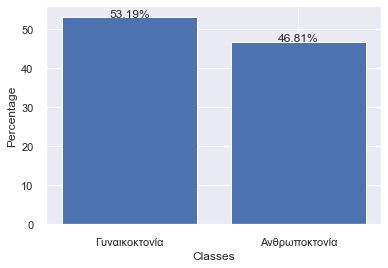

text     0
label    0
dtype: int64

In [68]:
label_distribution = (df['label'].value_counts() * 100) / len(df)

# Add value labels


def add_labels(x, y):
    for i in range(len(x)):
        plt.text(i, y[i], "%.2f" % round(y[i], 2) + "%", ha='center')


plt.bar(label_distribution.index, label_distribution)
add_labels(label_distribution.index, label_distribution)
plt.xlabel("Classes")
plt.ylabel("Percentage")
plt.show()

# See missing values:
df.isna().sum()


## Split data set to train, validate and test:


In [69]:
# df_train, df_test = model_selection.train_test_split(df, test_size=0.2, random_state=25)

# Split to train validate and test
df_train, df_validate, df_test = np.split(df.sample(frac=1, random_state=42), [
                                          int(.6*len(df)), int(.8*len(df))])

# print(f"No. of training examples: {df_train.shape[0]}")
# print(f"No. of testing examples: {df_test.shape[0]}")
# print(f"No. of validating examples: {df_validate.shape[0]}")

# Get X_train, y_train, X_val, y_val, X_test, y_test

X_train = df_train['text']
y_train = df_train['label']

X_val = df_validate['text']
y_val = df_validate['label']

X_test = df_test['text']
y_test = df_test['label']

print("Train set has total {0} entries with {1:.2f}% belonging to class \'Γυναικοκτονία' and {2:.2f}% to class \'Ανθρωποκτονία'.".format(len(X_train),
                                                                                                                                         (len(
                                                                                                                                             X_train[y_train == 'Γυναικοκτονία']) / (len(X_train)*1.))*100,
                                                                                                                                         (len(X_train[y_train == 'Ανθρωποκτονία']) / (len(X_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% belonging to class \'Γυναικοκτονία' and {2:.2f}% to class \'Ανθρωποκτονία'.".format(len(X_val),
                                                                                                                                              (len(
                                                                                                                                                  X_val[y_val == 'Γυναικοκτονία']) / (len(X_val)*1.))*100,
                                                                                                                                              (len(X_val[y_val == 'Ανθρωποκτονία']) / (len(X_val)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% belonging to class \'Γυναικοκτονία' and {2:.2f}% to class \'Ανθρωποκτονία'.".format(len(X_test),
                                                                                                                                        (len(
                                                                                                                                            X_test[y_test == 'Γυναικοκτονία']) / (len(X_test)*1.))*100,
                                                                                                                                        (len(X_test[y_test == 'Ανθρωποκτονία']) / (len(X_test)*1.))*100))


Train set has total 310 entries with 55.16% belonging to class 'Γυναικοκτονία' and 44.84% to class 'Ανθρωποκτονία'.
Validation set has total 103 entries with 44.66% belonging to class 'Γυναικοκτονία' and 55.34% to class 'Ανθρωποκτονία'.
Test set has total 104 entries with 55.77% belonging to class 'Γυναικοκτονία' and 44.23% to class 'Ανθρωποκτονία'.


In [70]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    """custom function to calculate accuracy for models"""
    if len(X_test[y_test == 0]) / (len(X_test)*1.) > 0.5:
        null_accuracy = len(X_test[y_test == 0]) / (len(X_test)*1.)
    else:
        null_accuracy = 1. - (len(X_test[y_test == 0]) / (len(X_test)*1.))
    t0 = time()
    class_fit = pipeline.fit(X_train, y_train)
    y_pred = class_fit.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format(
            (accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format(
            (null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time


In [71]:
cvec = CountVectorizer()
# lr = LogisticRegression()
# nb = MultinomialNB()
lsvm = SGDClassifier()
# 10.000 features:
n_features = np.arange(1000, 10001, 1000)


def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, ngram_range=(1, 1), classifier=lsvm):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy, tt_time = accuracy_summary(
            checker_pipeline, X_train, y_train, X_val, y_val)
        result.append((n, nfeature_accuracy, tt_time))
    return result


## TfIdfVectorizer:


In [72]:
# vectorizer = TfidfVectorizer()

# # remember to use the original X_train set

tvec = TfidfVectorizer()

X_train_tfidf = tvec.fit_transform(X_train)
X_train_tfidf.shape


(310, 12079)

In [73]:
%time
print("RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(
    vectorizer=tvec, ngram_range=(1, 2))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 7.15 µs
RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)

SGDClassifier()


Validation result for 1000 features
null accuracy: 100.00%
accuracy score: 93.20%
model is 6.80% less accurate than null accuracy
train and test time: 0.32s
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 100.00%
accuracy score: 93.20%
model is 6.80% less accurate than null accuracy
train and test time: 0.34s
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 100.00%
accuracy score: 93.20%
model is 6.80% less accurate than null accuracy
train and test time: 0.34s
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 100.00%
accuracy score: 90.29%
model is 9.71% less accurate than null accuracy
train and test time: 0.33s
----

## Chi2 Feature Selection:


Text(0.5, 0, '$\\chi^2$')

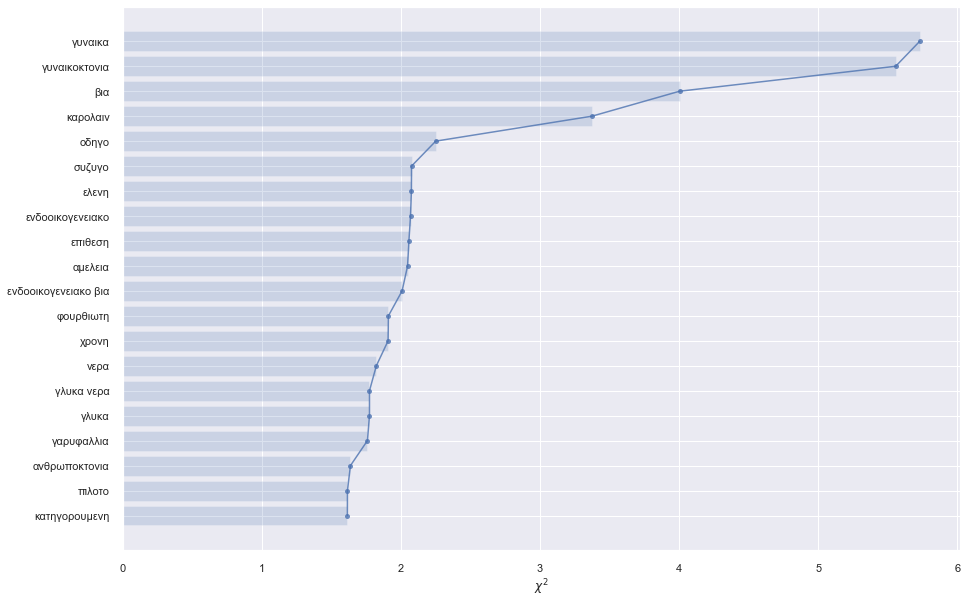

In [74]:
tvec = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

x_train_tfidf = tvec.fit_transform(X_train)


x_validation_tfidf = tvec.transform(X_val)

chi2score = chi2(x_train_tfidf, y_train)[0]

plt.figure(figsize=(15, 10))
wscores = zip(tvec.get_feature_names_out(), chi2score)
wchi2 = sorted(wscores, key=lambda x: x[1])
topchi2 = list(zip(*wchi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x, topchi2[1], align='center', alpha=0.2)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')



In [75]:
ch2_result = []
for n in np.arange(1000, 10001, 1000):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = SGDClassifier()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_val)
    ch2_result.append(score)
    print("chi2 feature selection evaluation calculated for {} features".format(n))

chi2 feature selection evaluation calculated for 1000 features
chi2 feature selection evaluation calculated for 2000 features
chi2 feature selection evaluation calculated for 3000 features
chi2 feature selection evaluation calculated for 4000 features
chi2 feature selection evaluation calculated for 5000 features
chi2 feature selection evaluation calculated for 6000 features
chi2 feature selection evaluation calculated for 7000 features
chi2 feature selection evaluation calculated for 8000 features
chi2 feature selection evaluation calculated for 9000 features
chi2 feature selection evaluation calculated for 10000 features


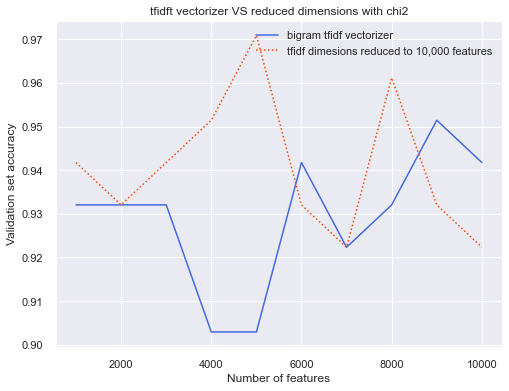

In [76]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt, columns=[
                                  'nfeatures', 'validation_accuracy', 'train_test_time'])

plt.figure(figsize=(8, 6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,
         label='bigram tfidf vectorizer', color='royalblue')
plt.plot(np.arange(1000, 10001, 1000), ch2_result,
         label='tfidf dimesions reduced to 10,000 features', linestyle=':', color='orangered')
# features limited within tfidft vectorizer and dimensions reduced with chi2
plt.title("tfidft vectorizer VS reduced dimensions with chi2")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()


In [77]:
# nfeatures_plot_tgt.head()

# print(feature_result_tgt)

## N-gram analysis:


In [78]:

def generate_N_grams(text, ngram=1):
    """"custom function to generate n-grams"""
    words = [word for word in text.split(
        " ") if word not in set(STOPWORDS_GREEK)]
    # print("Sentence after removing stopwords:", words)
    temp = zip(*[words[i:] for i in range(0, ngram)])
    ans = [' '.join(ngram) for ngram in temp]
    return ans


feminicide_values = defaultdict(int)
homicide_values = defaultdict(int)


# Get the count of every bigram in the columns of train data set where label="Γυναικοκτονία"
for text in df_train[df_train.label == "Γυναικοκτονία"].text:
    for word in generate_N_grams(text, 2):
        feminicide_values[word] += 1

# Get the count of every bigram in the columns of train data set where label="Ανθρωποκτονία"
for text in df_train[df_train.label == "Ανθρωποκτονία"].text:
    for word in generate_N_grams(text, 2):
        homicide_values[word] += 1


In [79]:
# focus on more frequently occuring words for every label=>
# sort in Descending Order with respect to the 2nd column in each of feminicide_values and homicide_values
df_feminicide = pd.DataFrame(
    sorted(feminicide_values.items(), key=lambda x: x[1], reverse=True))
df_homicide = pd.DataFrame(
    sorted(homicide_values.items(), key=lambda x: x[1], reverse=True))

# ten first values of first column
fc1 = df_feminicide[0][:10]
# ten first values of second column
fc2 = df_feminicide[1][:10]

# ten first values of first column
hc1 = df_homicide[0][:10]
# ten first values of second column
hc2 = df_homicide[1][:10]


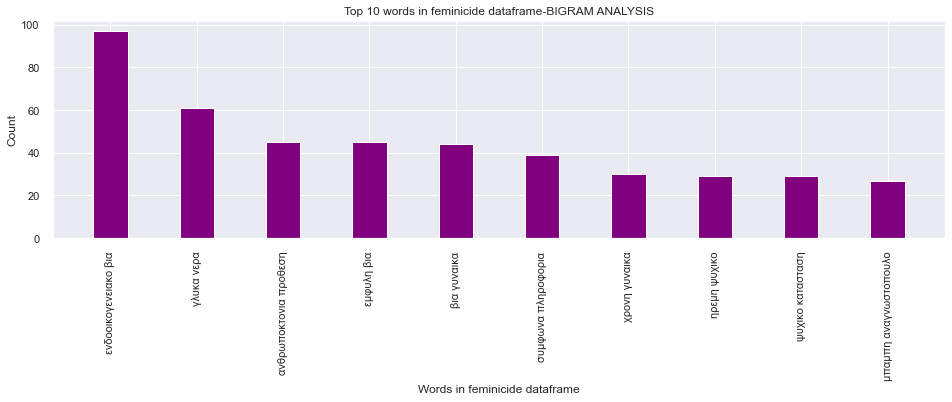

In [80]:
plt.figure(1, figsize=(16, 4))
plt.bar(fc1, fc2, color='purple',
        width=0.4)
plt.xlabel("Words in feminicide dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 words in feminicide dataframe-BIGRAM ANALYSIS")
# plt.savefig("feminicide-bigram.png")
plt.show()


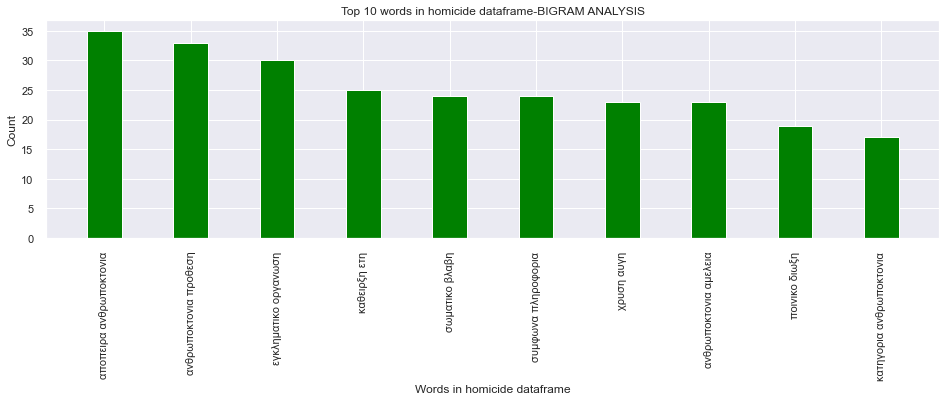

In [81]:
plt.figure(1, figsize=(16, 4))
plt.bar(hc1, hc2, color='green',
        width=0.4)
plt.xlabel("Words in homicide dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 words in homicide dataframe-BIGRAM ANALYSIS")
# plt.savefig("homicide-bigram.png")
plt.show()
